### Problem Statement
The aim here is to differentiate a plant seedling from a weed so that crop yields can be improved and better stewardship of the environment can be achieved. This dataset is provided by the Aarhus University Signal Processing group, in collaboration with University of Southern Denmark. It contains images of approximately 960 unique plants belonging to 12 species at several growth stages.

This is an image recognition problem where the aim is to classify the plant species from the image of the plant.

### Import Libraries

In [50]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
import cv2 
import seaborn as sns
from glob import glob
import itertools
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D,LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau, CSVLogger



### Data Acquisition and transformation

In [2]:
dim = 64 #image dimension for resizing

The dataset contains images of different sizes. Therefore, we resize the images for training.

In [3]:
#Read and resize images
path = '../input/plant-seedlings-classification/train/*/*.png' 
images = glob(path)

training_set = []
training_label = []
count = 1
num = len(images)
images_per_class = {}
for img in images:
    print(str(count) + "/" + str(num), end="\r")
    image = cv2.imread(img)
    label = img.split('/')[-2]
    if label not in images_per_class.keys():
        images_per_class[label] = []
    images_per_class[label].append(image)
    count += 1

In [4]:
training_set = np.asarray(training_set)  # training set
training_label = pd.DataFrame(training_label)  # training labels

In [6]:
training_set

array([], dtype=float64)

In [7]:
# Number of images per class
labels = []
for key,value in images_per_class.items():
    labels.extend([key]*len(value))
    print("{0} {1} images".format(key, len(value)))
    

Scentless Mayweed 516 images
Common wheat 221 images
Charlock 390 images
Black-grass 263 images
Sugar beet 385 images
Loose Silky-bent 654 images
Maize 221 images
Cleavers 287 images
Common Chickweed 611 images
Fat Hen 475 images
Small-flowered Cranesbill 496 images
Shepherds Purse 231 images


In [19]:
image_size = images_per_class['Scentless Mayweed'][0].shape

In [20]:
image_size

(142, 142, 3)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Training data class counts')

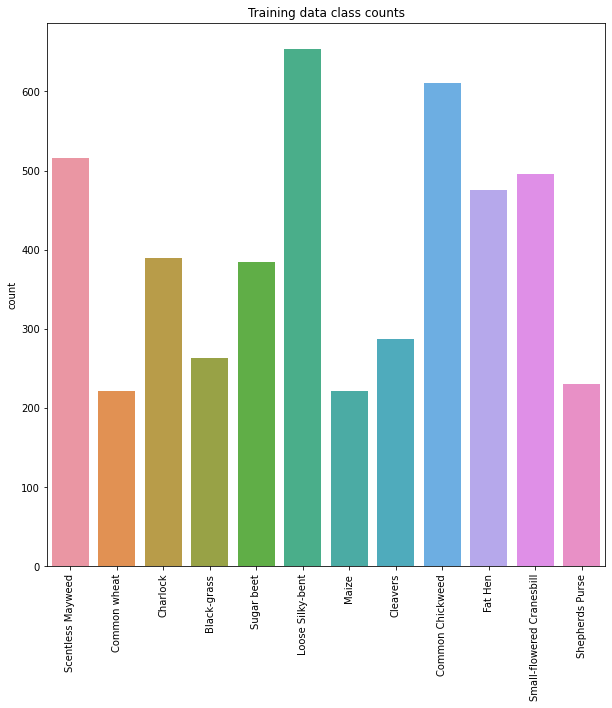

In [8]:
plt.figure(figsize = (10,10))
ax = sns.countplot(labels,label = images_per_class.keys())
ax.set_xticklabels(images_per_class.keys(),rotation = 90)
ax.set_title('Training data class counts')

In [9]:
def images_for_class(images_per_class,label):
    rows = 3
    cols = 3
    fig, axis = plt.subplots(rows, cols, figsize=(10, 10))

    count = 0
    for i in range(0, rows):
        for j in range(0, cols):
            axis[i, j].xaxis.set_ticklabels([])
            axis[i, j].yaxis.set_ticklabels([])
            axis[i, j].imshow(images_per_class[label][count])
            count += 1  
    plt.suptitle('Images for {}'.format(label),fontsize = 20)

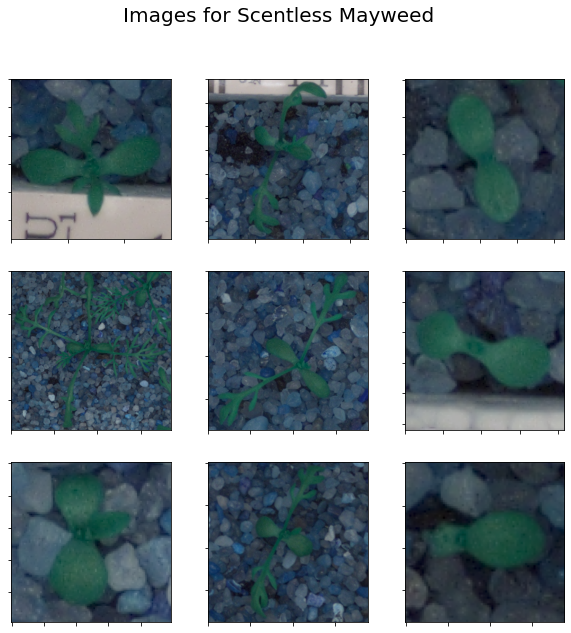

In [10]:
images_for_class(images_per_class,'Scentless Mayweed')

### Image Processing

We perform image processing to make the images more recognized for predictive modelling

In [11]:
   def resize_image(image, dim):
    return cv2.resize(image, (dim, dim),interpolation=cv2.INTER_AREA)#read and resize images

In [12]:
#define the image preprocessing pipeline

def image_processing_pipeline(image):
    #convert image to hsv for extracting colored objects
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #range in HSV to segment areas of green color
    lower_hsv = np.array([30, 100, 50])
    upper_hsv = np.array([85, 255, 255])
    #Creating mask by thresholding HSV image and obtaining only green color
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    # morphological operation called closing to close small holes with a structuring element to determine the nature of the operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    #perform segmentation using mask
    segment = cv2.bitwise_and(image, image, mask = mask)
    #sharpen image
    blurred = cv2.GaussianBlur(segment, (0,0), 3)
    sharpen = cv2.addWeighted(segment, 1.5, blurred, -0.5, 0) #sharpen image
    resize =  resize_image(sharpen,64)
    return mask,segment,resize


In [13]:
def image_preprocessing_function(image):
    _,_,resize = image_processing_pipeline(image.astype('uint8'))
    rescaled_image = resize/255
    return rescaled_image

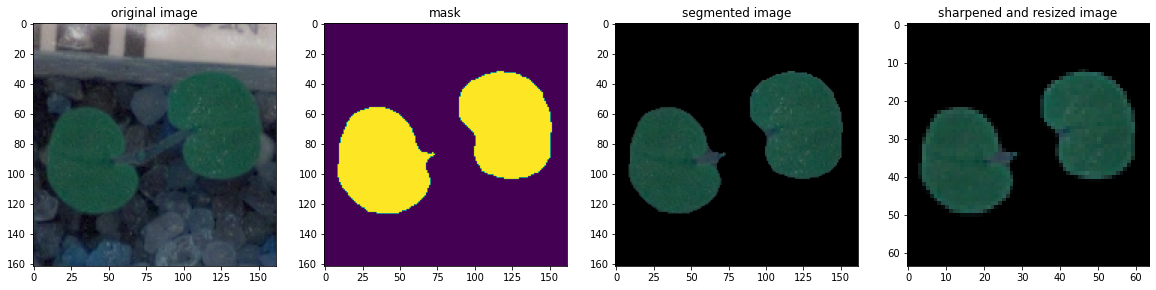

In [14]:
# Example output after image processing
# Test image to see the changes
image = images_per_class["Small-flowered Cranesbill"][90]

mask,segment,resize = image_processing_pipeline(image)
fig, axis = plt.subplots(1, 4, figsize=(20, 20))
axis[0].imshow(image)
axis[0].set_title('original image')
axis[1].imshow(mask)
axis[1].set_title('mask')
axis[2].imshow(segment)
axis[2].set_title('segmented image')
axis[3].imshow(resize)
axis[3].set_title('sharpened and resized image')
plt.show()


### Creating dataset with augmentation

In [22]:
# Generates batches of tensor image data with real-time data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=180,  # randomly rotate images in the range
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically 
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True,  # randomly flip images vertically
    preprocessing_function= image_preprocessing_function,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(preprocessing_function=image_preprocessing_function)

In [31]:
#Takes the path to a directory & generates batches of augmented data.
train_data = train_datagen.flow_from_directory(
        '../input/plant-seedlings-classification/train/',
        subset = 'training',
        target_size=(dim, dim),
        batch_size=32,
        shuffle = True,
        class_mode='categorical')

val_data = train_datagen.flow_from_directory(
        '../input/plant-seedlings-classification/train/',
        subset = 'validation',
        target_size=(dim, dim),
        batch_size=32,
        shuffle = True,
        class_mode='categorical')

Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.


In [32]:
x,y = next(train_data)
y = np.argmax(y, axis=1)
class_dict = train_data.class_indices
class_dict_inv = dict((v, k) for k, v in class_dict.items())
y_names = [class_dict_inv[key] for key in y]

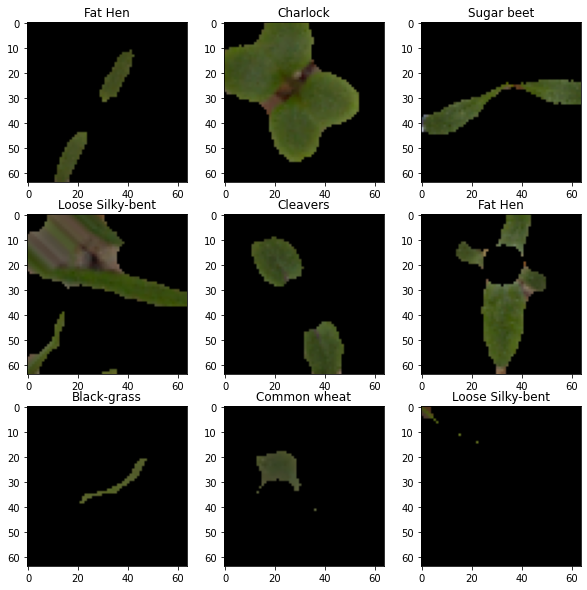

In [44]:
#Lets visualize the augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i])
    plt.title(y_names[i])
    plt.axis()

# Predictive modelling

In [45]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.figure(figsize = (10,10))
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Accuracy', fontsize = 20)
  plt.legend(['Training set','Validation set'])
  plt.show()
  
  plt.figure(figsize = (10,10))
  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epoch', fontsize = 20)
  plt.ylabel('Loss', fontsize = 20)
  plt.legend(['Training set','Validation set'])
  plt.show()

In [46]:
classes = len(set(train_data.classes))

In [51]:
def cnn_model(train_data,val_data,epochs,dim):
#Building the model using Keras functional API
    classes = len(set(train_data.classes))
    print("----Building the model----")
    i = Input(shape=(dim,dim,3)) #defining input
    x = Conv2D(32,3, activation= LeakyReLU(alpha = 0.3))(i) #adding convolution layers
    x = BatchNormalization()(x)
    x = Conv2D(32,3, activation= LeakyReLU(alpha = 0.3))(x) #adding convolution layers
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.15)(x)
    x = Conv2D(64,3, activation= LeakyReLU(alpha = 0.3))(x) #adding convolution layers
    x = BatchNormalization()(x)
    x = Conv2D(64,3, activation= LeakyReLU(alpha = 0.3))(x) #adding convolution layers
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.15)(x)
    x = Conv2D(128,3, activation= LeakyReLU(alpha = 0.3))(x) #adding convolution layers
    x = BatchNormalization()(x)
    x = Conv2D(128,3, activation= LeakyReLU(alpha = 0.3))(x) #adding convolution layers
    x = BatchNormalization()(x)
    x = MaxPooling2D(2)(x)
    x = Dropout(0.15)(x)
    x = Flatten()(x)
    x = Dense(256, activation=LeakyReLU(alpha = 0.3))(x)
    x = Dropout(0.25)(x)
    x = Dense(classes, activation= 'softmax')(x)

    model = Model(i,x)
    model.summary()
#Training the Convolutional Neural Network
    print("----Training the network----")
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(optimizer= optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    lrr = ReduceLROnPlateau(monitor='val_acc',    #reduce learning rate when there is no improvement in metrics
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)
    filepath="../output/weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoints = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                  verbose=1, save_best_only=True, mode='max')
    filepath="../output/weights.last_auto4.hdf5"
    checkpoints_full = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                     verbose=1, save_best_only=False, mode='max')
    callbacks_list = [checkpoints, lrr, checkpoints_full]
    
    r = model.fit(train_data, 
                  validation_data = val_data, 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [callbacks_list])
    print("Train score:", model.evaluate(train_data))
    print("Test score:", model.evaluate(val_data))
    
    return r,model 

In [52]:
r,model = cnn_model(train_data,val_data,40,64)

----Building the model----
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (No